# EE P 555 — Assignment: Power-System Fault Classification (Traditional ML + DNNs)

In this assignment, you will predict **power-system fault conditions** from 6 input measurements.
You will first implement a set of **traditional machine-learning baselines**, then implement and compare **three** PyTorch DNN formulations.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Traditional ML baselines for **6-class fault type** (train + test reports + confusion matrices).
2. **Part 2** — Regression-style DNN to predict 4 outputs (then round to bits).
3. **Part 3** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
4. **Part 4** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
5. **Part 5** — Brief discussion: which approach is best and why.
6. **Part 6** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [2]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — Traditional ML baselines (6-class fault type)

In this part, you will train and evaluate several **traditional ML models** for **multi-class fault type classification**.

Requirements:
- Use a **70% / 30%** train/test split (**stratified**).
- Use **RobustScaler** on features (**fit on train only**).
- Train the following models:
  - Logistic Regression
  - Perceptron
  - Linear SVM
  - Gaussian Naive Bayes
  - KNN
  - Decision Tree
  - Random Forest
- For **both train and test**, print:
  - `classification_report(...)`
  - `confusion_matrix(...)`

Notes:
- Do **not** plot confusion matrices in this part (print only).
- Use the provided mapping from 4-bit labels `[G, C, B, A]` to 6 fault types.


In [3]:
# ----------------------------
# Load data + map 4-bit labels -> 6-class fault type
# ----------------------------
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

CSV_PATH = "classData.csv"
df = pd.read_csv(CSV_PATH)

label_cols = ["G", "C", "B", "A"]
feature_cols = ["Ia", "Ib", "Ic", "Va", "Vb", "Vc"]

X = df[feature_cols].astype(np.float32).values
Y_bits = df[label_cols].astype(int).values  # (N,4) in order [G,C,B,A]

FAULT_NAMES = ["No Fault", "LG", "LL", "LLG", "LLL", "LLLG"]

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0  # No Fault
    if G == 1 and n_phase == 1: return 1  # LG
    if G == 0 and n_phase == 2: return 2  # LL
    if G == 1 and n_phase == 2: return 3  # LLG
    if G == 0 and n_phase == 3: return 4  # LLL
    if G == 1 and n_phase == 3: return 5  # LLLG
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print("Fault counts:", dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# ----------------------------
# 70/30 split (stratified by fault type)
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_fault, test_size=0.30, random_state=42, stratify=y_fault
)

# ----------------------------
# Robust scaling (fit on train only)
# ----------------------------
scaler = RobustScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# ----------------------------
# Reasonable hyperparameter defaults (you may adjust if needed)
# ----------------------------
DT_MAX_DEPTH = 10
DT_MIN_SAMPLES_LEAF = 5
DT_MIN_SAMPLES_SPLIT = 10

RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = 12
RF_MIN_SAMPLES_LEAF = 3
RF_MIN_SAMPLES_SPLIT = 8
RF_MAX_FEATURES = "sqrt"

KNN_K = 10

# ----------------------------
# TODO 1: Define the models (use the defaults above as a starting point)
# ----------------------------
models = {
    "LogReg": LogisticRegression(max_iter=1000,random_state=42),
    "Perceptron": Perceptron(max_iter=1000,random_state=42),
    "LinearSVM": LinearSVC(max_iter=5000,random_state=42),
    "GaussianNB": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=KNN_K),
    "DecisionTree": DecisionTreeClassifier(max_depth=DT_MAX_DEPTH,min_samples_leaf=DT_MIN_SAMPLES_LEAF,min_samples_split=DT_MIN_SAMPLES_SPLIT,random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=RF_N_ESTIMATORS,max_depth=RF_MAX_DEPTH,min_samples_leaf=RF_MIN_SAMPLES_LEAF,min_samples_split=RF_MIN_SAMPLES_SPLIT,max_features=RF_MAX_FEATURES,random_state=42),
}

# ----------------------------
# Evaluate each model (train + test)
# ----------------------------
for name, clf in models.items():
    clf.fit(X_train_s, y_train)

    for split_name, Xs, ys in [("Train", X_train_s, y_train), ("Test", X_test_s, y_test)]:
        preds = clf.predict(Xs)
        print(f"\n=== {name} | {split_name} ===")
        print(classification_report(ys, preds, target_names=FAULT_NAMES, digits=4))
        print("Confusion matrix:")
        print(confusion_matrix(ys, preds, labels=np.arange(len(FAULT_NAMES))))

Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}

=== LogReg | Train ===
              precision    recall  f1-score   support

    No Fault     0.3262    1.0000    0.4919      1655
          LG     0.0000    0.0000    0.0000       790
          LL     0.0000    0.0000    0.0000       703
         LLG     1.0000    0.1171    0.2097       794
         LLL     0.3254    0.1421    0.1978       767
        LLLG     0.0000    0.0000    0.0000       793

    accuracy                         0.3375      5502
   macro avg     0.2753    0.2099    0.1499      5502
weighted avg     0.2878    0.3375    0.2058      5502

Confusion matrix:
[[1655    0    0    0    0    0]
 [ 790    0    0    0    0    0]
 [ 579    0    0    0  124    0]
 [ 701    0    0   93    0    0]
 [ 658    0    0    0  109    0]
 [ 691    0    0    0  102    0]]

=== LogReg | Test ===
              precision    recall  f

/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me


=== RandomForest | Train ===
              precision    recall  f1-score   support

    No Fault     1.0000    0.9994    0.9997      1655
          LG     0.9950    1.0000    0.9975       790
          LL     1.0000    1.0000    1.0000       703
         LLG     0.9987    0.9950    0.9968       794
         LLL     0.8117    0.8149    0.8133       767
        LLLG     0.8190    0.8159    0.8174       793

    accuracy                         0.9467      5502
   macro avg     0.9374    0.9375    0.9375      5502
weighted avg     0.9468    0.9467    0.9467      5502

Confusion matrix:
[[1654    0    0    0    0    1]
 [   0  790    0    0    0    0]
 [   0    0  703    0    0    0]
 [   0    4    0  790    0    0]
 [   0    0    0    0  625  142]
 [   0    0    0    1  145  647]]

=== RandomForest | Test ===
              precision    recall  f1-score   support

    No Fault     1.0000    1.0000    1.0000       710
          LG     0.9855    1.0000    0.9927       339
          LL     1

## Part 2 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [4]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [5]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1=nn.Linear(input_dim,h1)
        self.bn1=nn.BatchNorm1d(h1)
        self.drop1=nn.Dropout(p_drop)
        self.fc2=nn.Linear(h1,h2)
        self.bn2=nn.BatchNorm1d(h2)
        self.drop2=nn.Dropout(p_drop)
        self.fc3=nn.Linear(h2,out_dim)

    def forward(self, x):
        x=self.drop1(torch.relu(self.bn1(self.fc1(x))))
        x=self.drop2(torch.relu(self.bn2(self.fc2(x))))
        x=self.fc3(x)
        return x

In [6]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model=DNN_Reg4(INPUT_DIM,H1,H2,OUT_DIM,DROPOUT_P).to(device)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LR,weight_decay=L2_WEIGHT_DECAY)

In [7]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            out=model(xb)
            loss=loss_fn(out,yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            avg=total/len(loader.dataset)
            print(f"Epoch {ep}: loss={avg:.4f}")

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

train_part1(model, train_loader_1)

Epoch 1: loss=0.7661
Epoch 500: loss=0.1030
Epoch 1000: loss=0.1026


In [8]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8897    0.7804    0.8315      2377
           C     0.9919    0.9174    0.9532      2263
           B     0.9458    0.9653    0.9555      3057
           A     0.9778    0.9800    0.9789      3144

   micro avg     0.9535    0.9190    0.9359     10841
   macro avg     0.9513    0.9108    0.9297     10841
weighted avg     0.9524    0.9190    0.9346     10841
 samples avg     0.6603    0.6492    0.6490     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2895  230]
 [ 522 1855]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3222   17]
 [ 187 2076]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2276  169]
 [ 106 2951]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2288   70]
 [  63 3081]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8908    0.7684    0.8251      1019
           C     0.9856    

/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

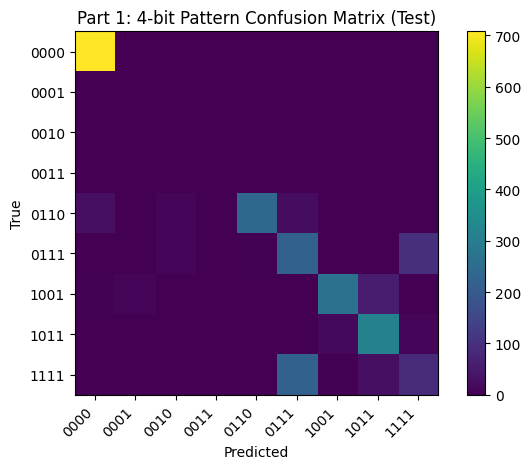

[[708   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 28   0  11   0 238  24   0   0   0]
 [  0   0  11   0   4 219   0   0  95]
 [  4  12   0   0   0   0 267  56   0]
 [  0   0   0   1   0   0  14 312  13]
 [  0   0   0   0   0 219   4  29  88]]


In [9]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 3 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [10]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [11]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1=nn.Linear(input_dim,h1)
        self.bn1=nn.BatchNorm1d(h1)
        self.drop1=nn.Dropout(p_drop)
        self.fc2=nn.Linear(h1,h2)
        self.bn2=nn.BatchNorm1d(h2)
        self.drop2=nn.Dropout(p_drop)
        self.fc3=nn.Linear(h2,out_dim)

    def forward(self, x):
        x=self.drop1(torch.relu(self.bn1(self.fc1(x))))
        x=self.drop2(torch.relu(self.bn2(self.fc2(x))))
        x=self.fc3(x)
        return x

In [12]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model=DNN_MultiLabel4(INPUT_DIM,H1,H2,OUT_DIM,DROPOUT_P).to(device)
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LR,weight_decay=L2_WEIGHT_DECAY)

In [13]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits=model(xb)
            loss=loss_fn(logits,yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            avg=total/len(loader.dataset)
            print(f"Epoch {ep}: loss={avg:.4f}")

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

train_part2(model, train_loader_2)

Epoch 1: loss=0.7090
Epoch 500: loss=0.2183
Epoch 1000: loss=0.2008


In [14]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8191    0.8629    0.8404      2377
           C     1.0000    0.9138    0.9550      2263
           B     0.9975    0.9280    0.9615      3057
           A     0.9997    0.9825    0.9910      3144

   micro avg     0.9561    0.9266    0.9411     10841
   macro avg     0.9541    0.9218    0.9370     10841
weighted avg     0.9595    0.9266    0.9422     10841
 samples avg     0.6654    0.6532    0.6546     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2672  453]
 [ 326 2051]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 195 2068]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2438    7]
 [ 220 2837]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2357    1]
 [  55 3089]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8267    0.8567    0.8414      1019
           C     1.0000    

/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/xuhaoran/EE555-Homeworks/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

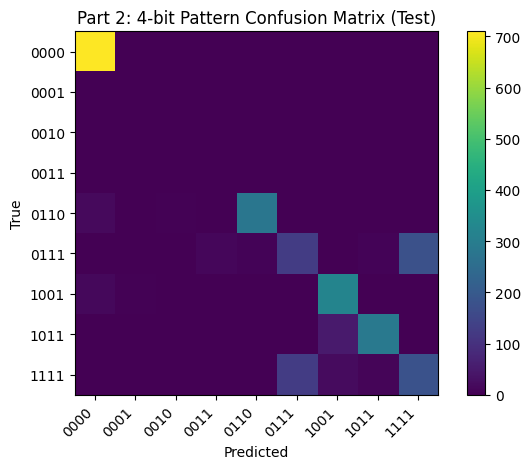

[[710   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 18   0   4   0 279   0   0   0   0]
 [  0   0   0  12   8 126   0   8 175]
 [ 15   3   0   0   0   0 321   0   0]
 [  0   1   0   0   0   0  51 288   0]
 [  0   0   0   0   2 125  22  11 180]]


In [15]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 4 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [16]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [17]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1=nn.Linear(input_dim,h1)
        self.bn1=nn.BatchNorm1d(h1)
        self.drop1=nn.Dropout(p_drop)
        self.fc2=nn.Linear(h1,h2)
        self.bn2=nn.BatchNorm1d(h2)
        self.drop2=nn.Dropout(p_drop)
        self.fc3=nn.Linear(h2,num_classes)

    def forward(self, x):
        x=self.drop1(torch.relu(self.bn1(self.fc1(x))))
        x=self.drop2(torch.relu(self.bn2(self.fc2(x))))
        x=self.fc3(x)
        return x

In [18]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model=DNN_MultiClass6(INPUT_DIM,H1,H2,6,DROPOUT_P).to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LR,weight_decay=L2_WEIGHT_DECAY)

In [19]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits=model(xb)
            loss=loss_fn(logits,yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            avg=total/len(loader.dataset)
            print(f"Epoch {ep}: loss={avg:.4f}")

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

train_part3(model, train_loader_3)

Epoch 1: loss=1.8517
Epoch 500: loss=0.5959
Epoch 1000: loss=0.6040



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9484    1.0000    0.9735      1655
          LG     0.8750    0.9481    0.9101       790
          LL     0.9038    0.9360    0.9196       703
         LLG     0.8844    0.9156    0.8998       794
         LLL     0.5411    0.5319    0.5365       767
        LLLG     0.5042    0.3796    0.4331       793

    accuracy                         0.8175      5502
   macro avg     0.7762    0.7852    0.7788      5502
weighted avg     0.8021    0.8175    0.8081      5502



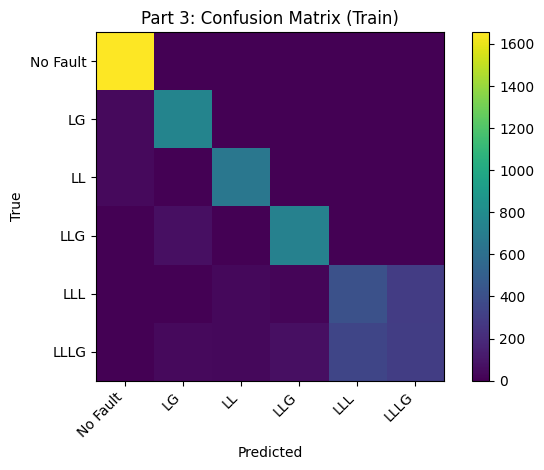


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9441    1.0000    0.9713       710
          LG     0.8788    0.9410    0.9088       339
          LL     0.9094    0.9336    0.9213       301
         LLG     0.9020    0.9206    0.9112       340
         LLL     0.5211    0.5258    0.5234       329
        LLLG     0.4883    0.3676    0.4195       340

    accuracy                         0.8143      2359
   macro avg     0.7740    0.7814    0.7759      2359
weighted avg     0.7995    0.8143    0.8053      2359



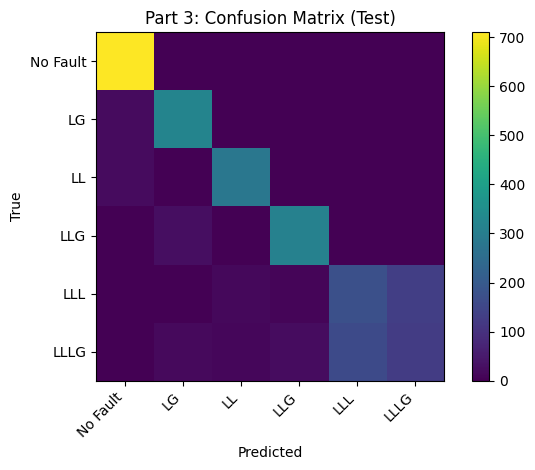

In [20]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 5 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 2–4. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 2 and Part 3), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1: Multi-label (Part 3) had the best per-bit F1 scores on test (~0.94 micro avg), better than regression (Part 2 ~0.94 but lower on G bit). Multi-class (Part 4) only got ~0.81 accuracy and realy struggled on LLL/LLLG. But multi-class has the advantege of never producing invlaid 4-bit patterns. Overall multi-label fits this datset best on metrics, tho multi-class is cleaner conceptualy.

- Q2: Yes some inconsistant 4-bit pattrens showed up in Part 2 and Part 3. The 4-bit pattern CMs were 9x9 instead of 6x6, meaning 3 extra invlaid patterns appeared (like combos that dont map to any fault). This happns because both models predict bits independantly with no constrant linking them, so impossible combinatons can occure.

- Q3: LLL and LLLG faults were the hardest to classfy. In Part 4 confusion matrix LLL only got F1=0.52 and LLLG got F1=0.42 on test. Probaly because LLL (0111) and LLLG (1111) have very similiar current/voltage signtures -- the only diffrence is the ground bit G, and when all 3 phases are faulted the ground path signal is hard to distingush.

## Part 6 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 5, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


You must write this part **from scratch** (no starter code is provided).


No Fault: 2365, Fault: 5496
Epoch 1: loss=0.7172
Epoch 500: loss=0.0651
Epoch 1000: loss=0.0655

=== Part 6 Binary | Train ===
              precision    recall  f1-score   support

    No Fault     0.9539    1.0000    0.9764      1655
       Fault     1.0000    0.9792    0.9895      3847

    accuracy                         0.9855      5502
   macro avg     0.9769    0.9896    0.9829      5502
weighted avg     0.9861    0.9855    0.9856      5502

[[1655    0]
 [  80 3767]]


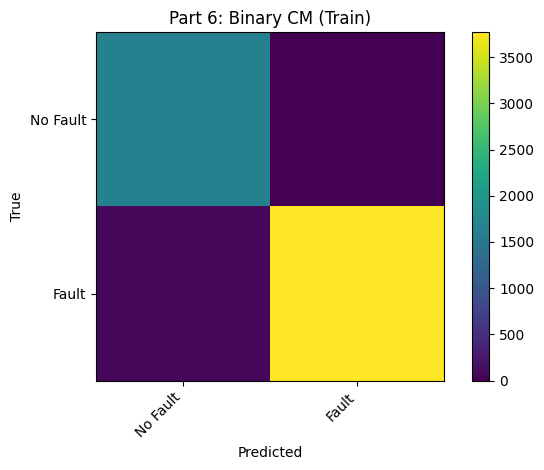


=== Part 6 Binary | Test ===
              precision    recall  f1-score   support

    No Fault     0.9634    1.0000    0.9813       710
       Fault     1.0000    0.9836    0.9917      1649

    accuracy                         0.9886      2359
   macro avg     0.9817    0.9918    0.9865      2359
weighted avg     0.9890    0.9886    0.9886      2359

[[ 710    0]
 [  27 1622]]


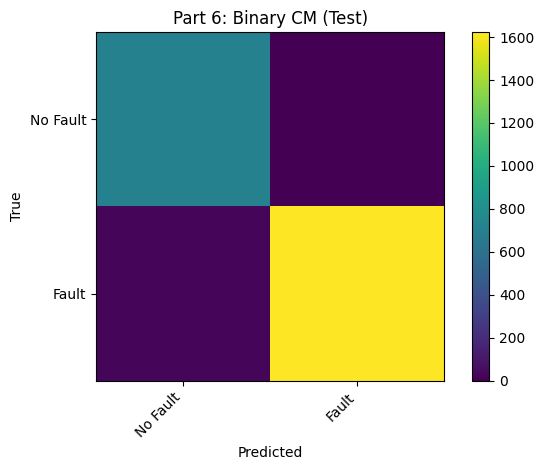

In [21]:
y_bin=np.zeros(len(y_fault),dtype=np.int64)
i=0
while i<len(y_fault):
    if y_fault[i]>0:
        y_bin[i]=1
    i+=1

print(f"No Fault: {(y_bin==0).sum()}, Fault: {(y_bin==1).sum()}")

X_tr6,X_te6,y_tr6,y_te6=train_test_split(X,y_bin,test_size=0.30,random_state=42,stratify=y_bin)

sc6=RobustScaler()
X_tr6_s=sc6.fit_transform(X_tr6).astype(np.float32)
X_te6_s=sc6.transform(X_te6).astype(np.float32)

Xtr6_t=torch.from_numpy(X_tr6_s)
Xte6_t=torch.from_numpy(X_te6_s)
ytr6_t=torch.from_numpy(y_tr6)
yte6_t=torch.from_numpy(y_te6)

loader6=DataLoader(TensorDataset(Xtr6_t,ytr6_t),batch_size=256,shuffle=True)

class DNN_Binary(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(6,16)
        self.bn1=nn.BatchNorm1d(16)
        self.drop1=nn.Dropout(0.25)
        self.fc2=nn.Linear(16,8)
        self.bn2=nn.BatchNorm1d(8)
        self.drop2=nn.Dropout(0.25)
        self.fc3=nn.Linear(8,2)

    def forward(self,x):
        x=self.drop1(torch.relu(self.bn1(self.fc1(x))))
        x=self.drop2(torch.relu(self.bn2(self.fc2(x))))
        x=self.fc3(x)
        return x

model6=DNN_Binary().to(device)
loss6=nn.CrossEntropyLoss()
opt6=torch.optim.Adam(model6.parameters(),lr=1e-3,weight_decay=1e-4)

model6.train()
ep=1
while ep<=1000:
    tot=0.0
    for xb,yb in loader6:
        xb=xb.to(device)
        yb=yb.to(device)
        opt6.zero_grad()
        out=model6(xb)
        l=loss6(out,yb)
        l.backward()
        opt6.step()
        tot+=l.item()*xb.size(0)
    if ep==1 or ep==500 or ep==1000:
        avg=tot/len(loader6.dataset)
        print(f"Epoch {ep}: loss={avg:.4f}")
    ep+=1

model6.eval()
with torch.no_grad():
    pred_tr6=torch.argmax(model6(Xtr6_t.to(device)),dim=1).cpu().numpy()
    pred_te6=torch.argmax(model6(Xte6_t.to(device)),dim=1).cpu().numpy()

BIN_NAMES=['No Fault','Fault']

print('\n=== Part 6 Binary | Train ===')
print(classification_report(y_tr6,pred_tr6,target_names=BIN_NAMES,digits=4))
cm_tr6=confusion_matrix(y_tr6,pred_tr6)
print(cm_tr6)
plot_cm(cm_tr6,'Part 6: Binary CM (Train)',BIN_NAMES)

print('\n=== Part 6 Binary | Test ===')
print(classification_report(y_te6,pred_te6,target_names=BIN_NAMES,digits=4))
cm_te6=confusion_matrix(y_te6,pred_te6)
print(cm_te6)
plot_cm(cm_te6,'Part 6: Binary CM (Test)',BIN_NAMES)